# 🐱 Cat Breed Explorer: Multimodal Search with CLIP + ChromaDB
Welcome to the Cat Breed Explorer!

This is an interactive demo that showcases the power of **multimodal search** using **CLIP embeddings**, **ChromaDB**, and **LLMs**.

**In this notebook, you'll explore**:

* 🧠 ChromaDB as a Vector Store: Efficient storage and retrieval of CLIP embeddings with metadata.

* 📸 Image-to-Text Search: Upload an image of a cat, and retrieve breed descriptions that match it.

* 🔍 Text-to-Image Search: Type a phrase like “a long-haired orange cat” and get images of matching breeds.

* 📚 LLM-Powered Q&A: Ask natural language questions about breeds (e.g. “Which cat is the most affectionate?”), and get friendly, detailed answers based on retrieved context.



This is a fun and educational demo built to show how you can combine vector similarity, RAG (Retrieval-Augmented Generation), and multimodal reasoning in a real-world use case — all through the lens of adorable felines.


In [1]:
!pip install --q git+https://github.com/gabya06/cat_breeds.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from io import BytesIO
import os

from dotenv import load_dotenv
from google import genai
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import  tqdm

In [3]:
from cat_breeds import (CatDataProcessor,
                        CatBreedQA,
                        ClipMatcher,
                        CatImageGeenerator)
from cat_breeds.utils.embedding_functions import (ClipTextEmbeddingFunction,
                                                  ClipImageEmbeddingFunction)
from cat_breeds.utils import utils

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
load_dotenv()
# load Gemini API Key
api_key = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

## 🐱 1. Fetch Cat Breed Metadata + Images

This section pulls data from the CatAPI and download images in the `images` folder

In [5]:
# If you dont have a CATAPI Key uncomment this and download the data from my git
# and comment out the first 2 lines in the next cell
# !wget "https://raw.githubusercontent.com/Gabya06/cat_breeds/refs/heads/main/data/breed_data.json" breeds_data.json
# try:
#   breeds_df = pd.read_json('breed_data.json')
# except Exception as e:
#   print(f"Error downloading breed_data.json from GitHub: {e}")

In [6]:
breeds_data = CatDataProcessor.get_breeds()

# Convert the data into a DataFrame for easy processing
breeds_df = pd.DataFrame(breeds_data)

# Organize data
breeds_df = breeds_df[['id', 'name', 'origin', 'temperament', 'description',
                       'hypoallergenic','shedding_level', "life_span",
                       'affection_level' , 'health_issues', 'image']]
breeds_df['image_url'] = breeds_df['image'].apply(lambda x: x['url'] if pd.notna(x) else None)

In [7]:
breeds_df.head(2)

,id,name,origin,temperament,description,hypoallergenic,shedding_level,life_span,affection_level,health_issues,image,image_url
0,abys,Abyssinian,Egypt,"Active, Energetic, Independent, Intelligent, G...","The Abyssinian is easy to care for, and a joy ...",0,2,14 - 15,5,2,"{'id': '0XYvRd7oD', 'width': 1204, 'height': 1...",https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg
1,aege,Aegean,Greece,"Affectionate, Social, Intelligent, Playful, Ac...",Native to the Greek islands known as the Cycla...,0,3,9 - 12,4,1,"{'id': 'ozEvzdVM-', 'width': 1200, 'height': 8...",https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg


## 🐾 2. Download Cat Images

In [11]:
images_paths = []
# download images
for row in breeds_data:
    breed_id = row['id']
    breed_name = row['name']
    try:
        # CatDataProcessor.download_images_per_breed(breed_id=breed_id,
        #                                        breed_name=breed_name, num_images=1)

        image = os.listdir(f'images/{breed_name}')[0]
        images_paths.append(image)
    except Exception as e:
        print(e)
        images_paths.append(None)

list index out of range


In [12]:
# process data for RAG Q&A
data = CatDataProcessor.process_data_for_rag(breeds_df)

# Keep important information
data = data[['id','breed','origin','affection_level', 'shedding_level', 'health_issues' ,
             'life_span_avg', 'image_url','cat_description']]

# assign image path
data = data.assign(image_path = images_paths)
data.dropna(subset=['image_path'], inplace = True)
data.image_path = data.apply(lambda x: f'images/{x["image_path"].split("_")[0]}/{x["image_path"]}', axis=1)

In [13]:
data.head()

,id,breed,origin,affection_level,shedding_level,health_issues,life_span_avg,image_url,cat_description,image_path
0,abys,Abyssinian,Egypt,NaN,NaN,NaN,14.5,https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg,"The Abyssinian is easy to care for, and a joy ...",images/Abyssinian/Abyssinian_1.jpg
1,aege,Aegean,Greece,NaN,NaN,NaN,10.5,https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg,Native to the Greek islands known as the Cycla...,images/Aegean/Aegean_1.jpg
2,abob,American Bobtail,United States,NaN,NaN,NaN,13.0,https://cdn2.thecatapi.com/images/hBXicehMA.jpg,American Bobtails are loving and incredibly in...,images/American Bobtail/American Bobtail_1.jpg
3,acur,American Curl,United States,NaN,NaN,NaN,14.0,https://cdn2.thecatapi.com/images/xnsqonbjW.jpg,Distinguished by truly unique ears that curl b...,images/American Curl/American Curl_1.jpg
4,asho,American Shorthair,United States,NaN,NaN,NaN,16.0,https://cdn2.thecatapi.com/images/JFPROfGtQ.jpg,The American Shorthair is known for its longev...,images/American Shorthair/American Shorthair_1...


In [14]:
data.shape

(66, 10)

## 🧠 3. Generate Embeddings for Text and Images using CLIP

In [15]:
# Generate CLIP embeddings for images and breed descriptions
embedding_documents = []
image_embeddings = []
text_embeddings = []
metadatas = []

# Loop through each row and generate embeddings for the image & cat_description
for idx, row in tqdm(data.iterrows(), total = len(data)):
    image_path = row['image_path']
    text = row['cat_description']

    image_embedding = ClipMatcher.preprocess_image(image_path=image_path) # preprocess image
    text_embedding = ClipMatcher.preprocess_text(text_list=[text]) # preprocess text

    if image_embedding is not None:
        embedding_documents.append(f"Image: {row['breed']}")  # Document description
        image_embeddings.append(image_embedding)
        text_embeddings.append(text_embedding)

        # Add breed metadata
        breed_metadata = {
            "breed": row["breed"],
            "origin": row["origin"],
            "affection_level": row["affection_level"],
            "health_issues": row["health_issues"],
            "shedding_level": row["shedding_level"]
        }
        metadatas.append(breed_metadata)

100%|██████████| 66/66 [00:32<00:00,  2.01it/s]


In [16]:
# Verify lengths match across documents and embeddings
len(embedding_documents), len(image_embeddings), len(metadatas), len(text_embeddings)

(66, 66, 66, 66)

## 💾 4. Store in ChromaDB (Embeddings + Vector Search)

Create 2 collections:
* One for cat description text storing CLIP text embeddings - so that we can query text
* One for cat images storing CLIP image embeddings - so that we can query using images

In [17]:
import chromadb
from typing import List
def create_chromadb(
    db_name: str, metadatas: List, embedding_function, delete_exisiting: bool = True
):
    """
    Create ChromaDB collection with given name and embedding function.

    Parameters
    ----------
    db_name : str
        Name of the ChromaDB collection.
    metadatas : List
        Metadata associated with each document.
    embedding_function : EmbeddingFunction
        Function to generate embeddings.
    delete_exisiting: Bool
        Whether to delete exisiting chromaDB before adding documents. Defaults to True
    """

    # create db and include metadata
    chroma_client = chromadb.Client()
    # chroma_client = chromadb.Client(persist_directory="./my_chroma_db")
    # delete existing collection
    if delete_exisiting:
        try:
            chroma_client.delete_collection(name=db_name)
        except Exception:
            pass
    # db = chroma_client.create_collection(name=db_name, embedding_function=embedding_function)
    db = chroma_client.get_or_create_collection(
        name=db_name, embedding_function=embedding_function
    )

    return db

In [18]:
# create text and image collections (Databases) using CLIP embeddings functions
text_embedding_fn = ClipTextEmbeddingFunction()
text_collection = create_chromadb(db_name="cat_breed_texts", embedding_function=text_embedding_fn,
                                metadatas=metadatas)

image_embedding_fn = ClipImageEmbeddingFunction()
image_collection = create_chromadb(db_name="cat_breed_images", embedding_function=image_embedding_fn,
                                 metadatas=metadatas)


<ipython-input-18-d5c1c5efed88>:2: DeprecationWarning: The class ClipTextEmbeddingFunction does not implement __init__. This will be required in a future version.
  text_embedding_fn = ClipTextEmbeddingFunction()
<ipython-input-18-d5c1c5efed88>:6: DeprecationWarning: The class ClipImageEmbeddingFunction does not implement __init__. This will be required in a future version.
  image_embedding_fn = ClipImageEmbeddingFunction()


In [19]:
text_collection.peek(1)

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['embeddings', 'metadatas', 'documents'],
 'data': None,
 'metadatas': []}

In [20]:
# add metadata information to facilitate filtering
metadatas = [
    {
        "breed": row["breed"],
        "origin": row["origin"],
        "affection_level": row["affection_level"],
        "health_issues": row["health_issues"],
        "shedding_level": row["shedding_level"]
    }
    for _, row in data.iterrows()
]

In [21]:
# add documents and text embeddings to text collection
text_collection.add(
    documents=[row['cat_description'] for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=text_embeddings,
    metadatas=metadatas
)

In [22]:
# add documents and image embeddings to image collection
image_collection.add(
    documents=[f"Image: {row['breed']}" for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=image_embeddings,
    metadatas=metadatas
)


In [23]:
# let s take a look at text db ids
text_collection.peek(10)['ids']

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [24]:
image_collection.peek(1)['embeddings'].shape

(1, 512)

## 😸 5. Let's explore our images and text information about cats! 👀



In [25]:
# Create cat QA
cat_qa = CatBreedQA(text_db=text_collection, image_db=image_collection,
                    data=data,client=client)

#### 🐱 RAG: Ask "What is the most affectionate cat?"

In [26]:
question_1 = "what cat is the most affectionate?"

In [27]:
results_1 = cat_qa.query(query=question_1, mode='text', n_results=5)

### Results Inspection: 👓

* Ids corresponding to query results in our data. Notice that since we asked for 5 results back we get back 5 ids
* Documents corresponding to cat_description in our data
* Metadata of results
* Distances: these are the euclidean distances between each result and the query

In [28]:
results_1

{'ids': [['42', '24', '17', '39', '8']],
 'embeddings': None,
 'documents': [['The Munchkin is an outgoing cat who enjoys being handled. She has lots of energy and is faster and more agile than she looks. The shortness of their legs does not seem to interfere with their running and leaping abilities. Their temperament is described as Agile, Easy Going, Intelligent, Playful. They are known to be nan, tend to nan and nan. They typically live around 12.5 years.',
   'The Cymric is a placid, sweet cat. They do not get too upset about anything that happens in their world. They are loving companions and adore people. They are smart and dexterous, capable of using his paws to get into cabinets or to open doors. Their temperament is described as Gentle, Loyal, Intelligent, Playful. They are known to be nan, tend to nan and nan. They typically live around 11.0 years.',
   'Perhaps the only thing about the California spangled cat that isn’t wild-like is its personality. Known to be affectionate,

### Generate Final Answer using LLM (GEMINI) ✔

In [29]:
# Get LLM to provide the final answer
print(cat_qa.get_answer())

As an expert on cat breeds, I can help you with that! According to the information I have access to, both the California Spangled cat and the LaPerm are known to be affectionate. The California Spangled cat is also gentle and sociable, enjoying time with its owners, while the LaPerm is also gentle, active, and content to be a lap cat, happily receiving attention.



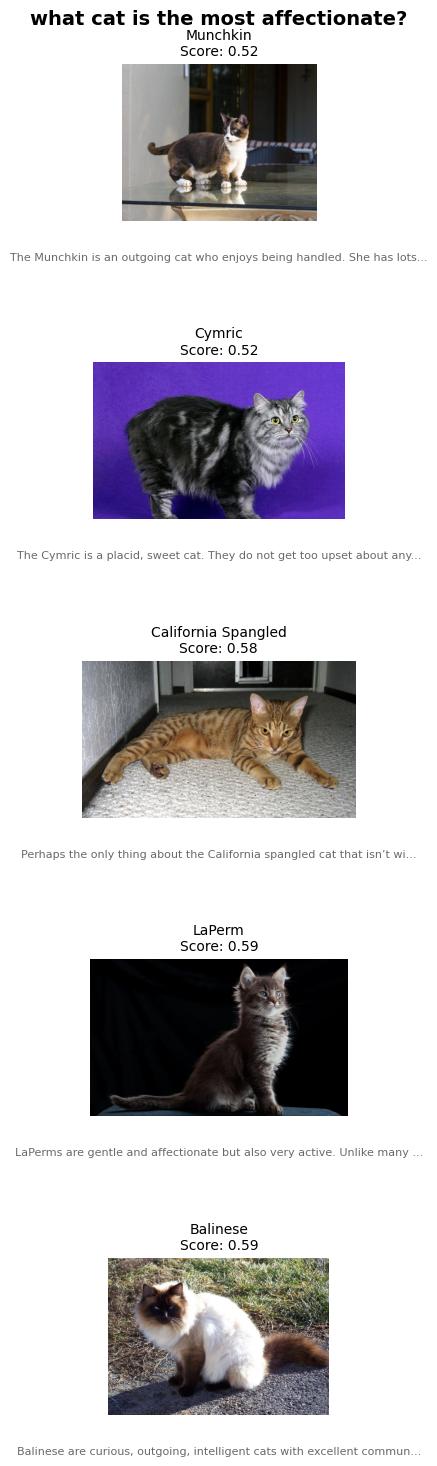

In [30]:
# Display the most affectionate cats!
cat_qa.display()

## Text to Image Query

#### 🐱 RAG: Ask "A long haired white cat"

In [ ]:
# Question 2: Let's find a white long haired cat

In [31]:
results_2 = cat_qa.query(query="I want to see a long haired white cat",
                         mode='text_to_image')


In the below results we can see that we do not obtain the same information in
documents, since this uses the text embedding as a look up in the image collection. In this way, the query compares 'long haired cat' with the document text in the image collection ('an image of a Siberian') which is anchored to those images using CLIP.

In [32]:
results_2

{'ids': [['40', '63', '49']],
 'embeddings': None,
 'documents': [['Image: Maine Coon',
   'Image: Turkish Angora',
   'Image: Ragamuffin']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'breed': 'Maine Coon', 'origin': 'United States'},
   {'origin': 'Turkey', 'breed': 'Turkish Angora'},
   {'origin': 'United States', 'breed': 'Ragamuffin'}]],
 'distances': [[1.369156002998352, 1.3742913007736206, 1.3910390138626099]]}

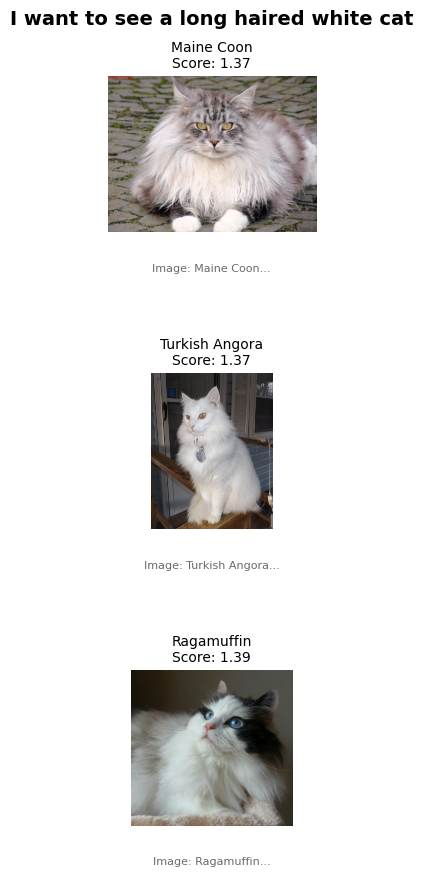

In [33]:
cat_qa.display()

### Ask Gemini for the final answer

In [34]:
print(cat_qa.get_answer())

As an expert on cat breeds, I know there are many long-haired cat breeds that have white coats! For example, the Turkish Angora is a breed of domestic cat that comes in a variety of colors, one of which is white! They are known for their long, silky coats and playful personality. Another breed that sometimes comes in white is the Maine Coon. These cats are one of the largest domesticated breeds and have long hair. Lastly, the Ragamuffin cat breed comes in a variety of colors, including white, and is known for being long haired.



## 🐾  6. Image Matching - Cat Discovery 😼

In this section, I test out a few photos of my cats and match them with the images in the cat database.


#### What type of cat is it?

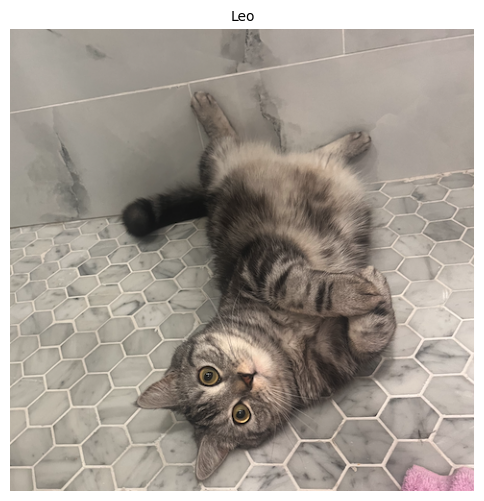

In [35]:
new_image_path = 'images/my_pets/leo_1.png'

fig, ax = plt.subplots(figsize=(8,6))
img = Image.open(new_image_path)

ax.imshow(img)
ax.set_title(f"Leo", fontsize=10)
ax.axis('off')
plt.show(fig)

In [36]:
# embed Leo's picture
new_image_embeddings = ClipMatcher.preprocess_image(new_image_path)

In [37]:
results_3 = cat_qa.query(query='What kind of cat is this?', mode='image',
                         image_path=new_image_path, n_results=2)

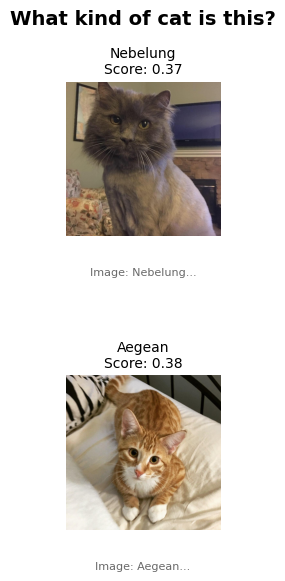

In [38]:
cat_qa.display()

In [39]:
print(cat_qa.get_answer())

As an expert on cat breeds, based on my knowledge, one of the cats is a Nebelung and the other is an Aegean.



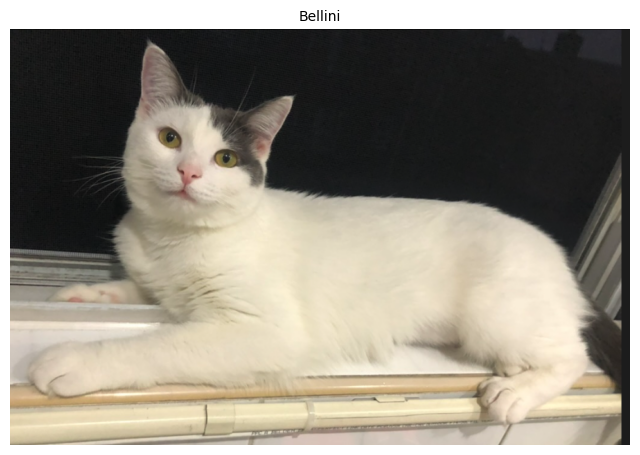

In [40]:
new_image_path_2 = 'images/my_pets/bellini_1.png'

fig, ax = plt.subplots(figsize=(8,6))
img = Image.open(new_image_path_2)

ax.imshow(img)
ax.set_title(f"Bellini", fontsize=10)
ax.axis('off')
plt.show(fig)

In [41]:
# embed Leo's picture
new_image_embeddings_2 = ClipMatcher.preprocess_image(new_image_path_2)

In [42]:
results_4 = cat_qa.query(query='What kind of cat is this?', mode='image',
                         image_path=new_image_path_2, n_results=2)

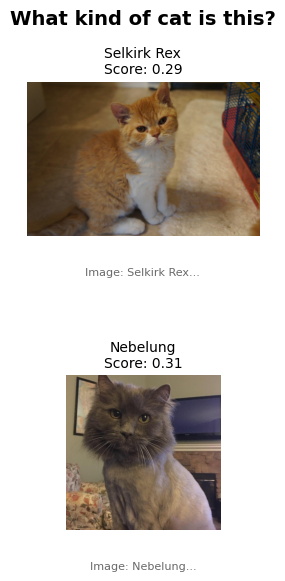

In [43]:
cat_qa.display()

In [44]:
print(cat_qa.get_answer())

I am unable to identify the cat in question without an image. However, I can still assist you in identifying the cat if you provide additional information on the cat in question, such as coat type, color, and approximate size.



In [45]:
results_4

{'ids': [['54', '43']],
 'embeddings': None,
 'documents': [['Image: Selkirk Rex', 'Image: Nebelung']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'origin': 'United States', 'breed': 'Selkirk Rex'},
   {'breed': 'Nebelung', 'origin': 'United States'}]],
 'distances': [[0.2906849682331085, 0.3061492443084717]]}

### Bonus Section: Generate Similar Images!

In [48]:
cat_generator = CatImageGeenerator(client=client)

In [49]:
new_image_dirs = []
for ix, i in enumerate(results_3['ids'][0]):
    i = int(i)
    breed = data.iloc[i]['breed']
    cat_description = data.iloc[i]['cat_description']

    prompt = f"Generate an image of a {breed} cat. It is {cat_description}."
    image_data = cat_generator.generated_cat_images(prompt=prompt)
    breed_folder = f"generated_images/{breed}"

    if not os.path.exists(breed_folder):
        os.makedirs(breed_folder)

    if image_data:
        try:
            image = Image.open(BytesIO(image_data))
            filename = f"{breed.replace(' ', '_')}_{ix+1}.png"
            filepath = os.path.join(breed_folder, filename)
            image.save(filepath, "PNG")
            print(f" Generated and saved {filename} for {breed}")
            outpath = f'generated_images/{breed}/{filename}'
            new_image_dirs.append(outpath)

        except Exception as e:
            print(f" Error saving image for {breed} (image {ix+1}): {e}")

 Generated and saved Nebelung_1.png for Nebelung
 Generated and saved Aegean_2.png for Aegean


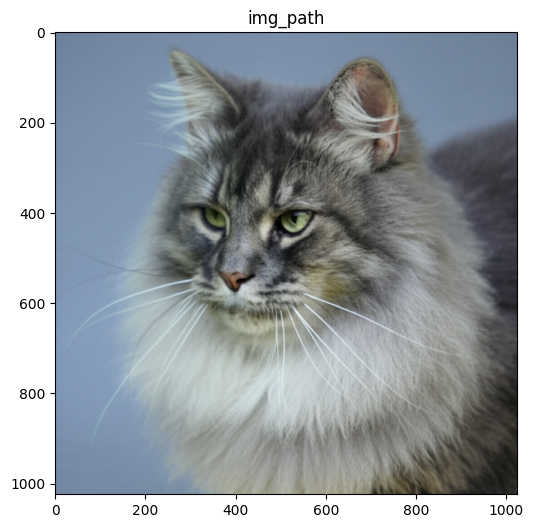

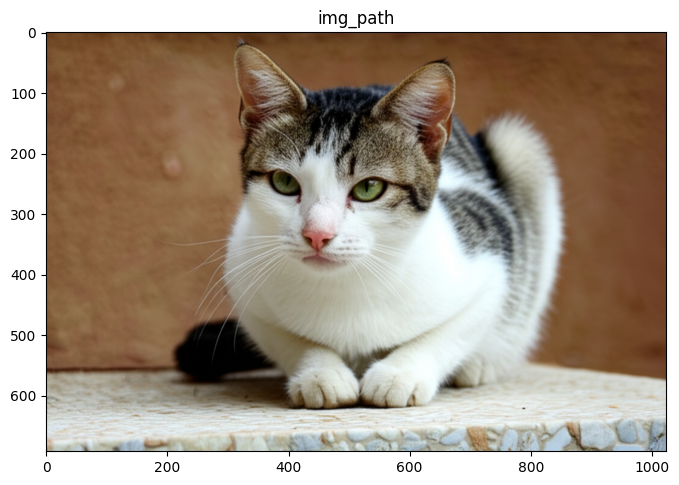

In [50]:
for img_pth in new_image_dirs:
    try:
        img = Image.open(img_pth).convert("RGB")
        fig, ax = plt.subplots(figsize = (8,6), facecolor="white")
        ax.imshow(img)
        ax.set_title(f"img_path")
        plt.show(fig)
    except Exception as e:
        print(f"could not open {img_pth}: {e}")

## 🧩 6. Image Matching (CLIP Similarity)

In [51]:
import torch

In [52]:
predicted_breed = ClipMatcher.predict_breed(
    breed_names=data.breed.tolist(),
    text_embeddings=torch.tensor(text_embeddings),
    image_embedding=torch.tensor(new_image_embeddings)
)

In [53]:
print(f"Leo's predicted breed is {predicted_breed}.")

Leo's predicted breed is American Shorthair.


In [58]:
cat_qa.query(query=f'What is a {predicted_breed}', mode='text', n_results=1)

{'ids': [['4']],
 'embeddings': None,
 'documents': [['The American Shorthair is known for its longevity, robust health, good looks, sweet personality, and amiability with children, dogs, and other pets. Their temperament is described as Active, Curious, Easy Going, Playful, Calm. They are known to be nan, tend to nan and nan. They typically live around 16.0 years.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'breed': 'American Shorthair', 'origin': 'United States'}]],
 'distances': [[0.3597831726074219]]}

In [59]:
cat_qa.get_answer()

'Ah, the American Shorthair! From my knowledge base, I can tell you that the American Shorthair is known for several wonderful traits. These cats are known for their longevity, robust health, good looks, sweet personality, and how well they get along with children, dogs, and other pets! People describe their temperament as active, curious, easy-going, playful, and calm. These cats are expected to live for around 16 years.\n'

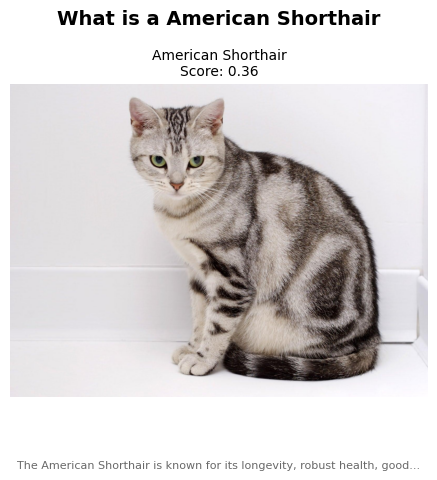

In [60]:
cat_qa.display()

In [57]:
predicted_breed_2 = ClipMatcher.predict_breed(
    breed_names=data.breed.tolist(),
    text_embeddings=torch.tensor(text_embeddings),
    image_embedding=torch.tensor(new_image_embeddings_2)
)
print(f"Bellini's predicted breed is {predicted_breed_2}.")

Bellini's predicted breed is American Shorthair.


In [61]:
cat_qa.query(query=f'What is a {predicted_breed_2}', mode='text', n_results=1)

{'ids': [['4']],
 'embeddings': None,
 'documents': [['The American Shorthair is known for its longevity, robust health, good looks, sweet personality, and amiability with children, dogs, and other pets. Their temperament is described as Active, Curious, Easy Going, Playful, Calm. They are known to be nan, tend to nan and nan. They typically live around 16.0 years.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'breed': 'American Shorthair', 'origin': 'United States'}]],
 'distances': [[0.3597831726074219]]}